# Overview
We want to provide topics to RecoHub users to give them a high-level view of the issues that are present in the searches. This notebook in particular will investigate modeling these topics using Latent Dirichlet Allocation (LDA) provided by the `sklearn` package.  

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.corpora as corpora

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from time import time

def get_top_words(model, feature_names, n_top_words):
    results = []
    for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #%d: " % topic_idx
        message = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        results.append(message)
    return results
    
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
def get_top_topics(document, model, model_vectorizer, hard_clustering=True, threshold=0.5):

    tdm = model_vectorizer.transform([document])

    results = []
    scores = []
    for topic, topic_dist in enumerate(model.components_):
        score = cosine_similarity(tdm, topic_dist.reshape(1, -1))
#         print("score: {}".format(score[0][0]))
        scores.append(score[0][0])
        if score >= threshold:
            results.append(topic)
                
                
    if results and not hard_clustering:
        return results, sorted(scores, reverse=True)
    else:
        return [np.argmax(scores)], sorted(scores, reverse=True) 
    
    
from collections import Counter
def get_doc_counts_per_topic(documents, model, vectorizer, hard_clustering=True, threshold=0.5):
    # the initialization step is done 
    initial_values = [(idx, 0) for idx in range(model.n_components)]
    counter = Counter()
    dict.update(counter, initial_values)

    for doc in documents:
        counter.update(get_top_topics(doc, model, vectorizer, hard_clustering, threshold)[0])

    return counter

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%pylab inline
pylab.rcParams['figure.figsize'] = (25, 6)

def plot_doc_counts(counter):
    labels, values = zip(*counter.most_common())

    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

    
    
    
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')

MIN_SENTENCE_LENGTH = 15
MAX_SENTENCE_LENGTH = 200
def find_best_sentence(documents, key_terms):
    """Choose the sentence with the highest representation of key terms. Vectorize with
    CountVectorizer and use the dot product score each sentence.
    
    :param documents: A list of string documents.
    :param key_terms: A string of words.
    """
    sentences = [sentence for document in documents for sentence in sent_tokenize(document)
                 if is_presentable(sentence)]
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(sentences)
    key_term_vector = vectorizer.transform([key_terms])

    scores = sentence_vectors @ key_term_vector.transpose()
    sentence_to_score = dict(zip(sentences, scores))
    return max(sentence_to_score, key=sentence_to_score.get)


def is_presentable(sentence):
    """Indicate if a string is free of code or stack traces."""
    bad_characters = ['\n', '`', '"', ':', '=', '{', '}', '--', '[', ']', '/', '\\']
    return (MIN_SENTENCE_LENGTH < len(sentence) < MAX_SENTENCE_LENGTH and
            not any([char in sentence for char in bad_characters]))


Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package punkt to /home/michael/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/michael/recohub-ml/venv/local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


There are three corpora of search queries with varying lengths. These are stored locally and can be loaded with the `corpora.load()` function. We'll first take a look at the `vmware-last-week` corpus which contains searches from the last week

In [53]:
import pandas as pd
corpus = corpora.load("../corpora/vmware-last-week")

# convert the list of Search objects into a dataframe
corpus_df = pd.DataFrame([vars(c) for c in corpus])
print("Total number of queries: {}".format(len(corpus_df)))

# For our current purposes, the timestamp isn't needed
corpus_df = corpus_df.drop(columns=["timestamp"])
corpus_df.head()

Total number of queries: 100


,body,session_id
0,"We tried to update VCA 6.5.0.14000 to 6.5.0.20000, the update failed and now the vCenter is no longer accessible. Giving us a 503 server unavailable after reboot.",ef2c1977-cfe1-4fc9-8e47-4056c4433f56
1,crash of esxi prevents migration,a0528909-8dae-4f71-8ea6-f42c618dd8a7
2,We would wish to know the vTPM supports from which version of ESXi version,153bdceb-3e88-4253-ba90-bd7d66a9a660
3,search,6ecc602e-87c3-4272-a9ff-cab08090f828
4,"We perform VM image backups via Avamar Server. Since 4/26/18 we have been unable to backup VMs within a specific DC in a VCenter instance that contains multiple DCs.\n\nBackup software indicates the following issue:\n\nAttempting to read VMX File, URL to connect : https://VC-SITES:443/folder/0BPW7217/0BPW7217.vmx?dcPath=DC+-+FOREST+PARK&dsName=VMFS-FPARK-DS01\nERR : Server returned HTTP response code: 500 for URL: https://VC-SITES:443/folder/0BPW7217/0BPW7217.vmx?dcPath=DC+-+FOREST+PARK&dsName=VMFS-FPARK-DS01\n\nWe've validated this symptom in a web browser - can navigate folder structure and read/download .vmx files for VMs with the exception of VMs in this particular DC.\n\nSo far we have rebooted VCenter, both ESXi hosts in the target DC, and migrated VMs between the two hosts. Issue persists.",04a1538c-bcb9-49da-89d6-505a8d8a50d9


In order to perform LDA on these queries, the `sklearn.CountVectorizer` will be used to create a feature vector for each query where there is a feature for every unique word in the vocabulary of all documents and the value of that feature is the total count of the corresponding word in that particular document. 

In [54]:
# Each topic has the same number of features as determined by the CountVectorizer. 
# The `max_features` parameters will limit each vector to the top `n` features based off of term frequency.  

# n_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,
#                                 max_features=n_features,
                                stop_words='english'
                               )
# create a list of just the bodies
bodies = [c.body for c in corpus]
tf = tf_vectorizer.fit_transform(bodies)

In [55]:
tf

<100x1036 sparse matrix of type '<class 'numpy.int64'>'
	with 1826 stored elements in Compressed Sparse Row format>

With the vectors stored in the `tf` object, we can find the topics via LDA

In [56]:
num_topics = 10

lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=-1,
                               )
lda.fit(tf)
model = lda
print("Number of features: {}".format(len(model.components_[0])))

Number of features: 1036


Now that we have the `lda` model, we can look at the top weighted words for each topic and the number of documents within each topic.

Topic #0: new scsicontroller cve vcan powercli
Topic #1: vcenter problem host vmware alerts
Topic #2: error failed connect process peer
Topic #3: esxi host lost version firmware
Topic #4: host stores cluster data dvs
Topic #5: cluster server error dc vmfs
Topic #6: vcenter vrealize host update assistance
Topic #7: server vcenter com psc appliance
Topic #8: vm disk host network hosts
Topic #9: 05 level 12pm investigate customer


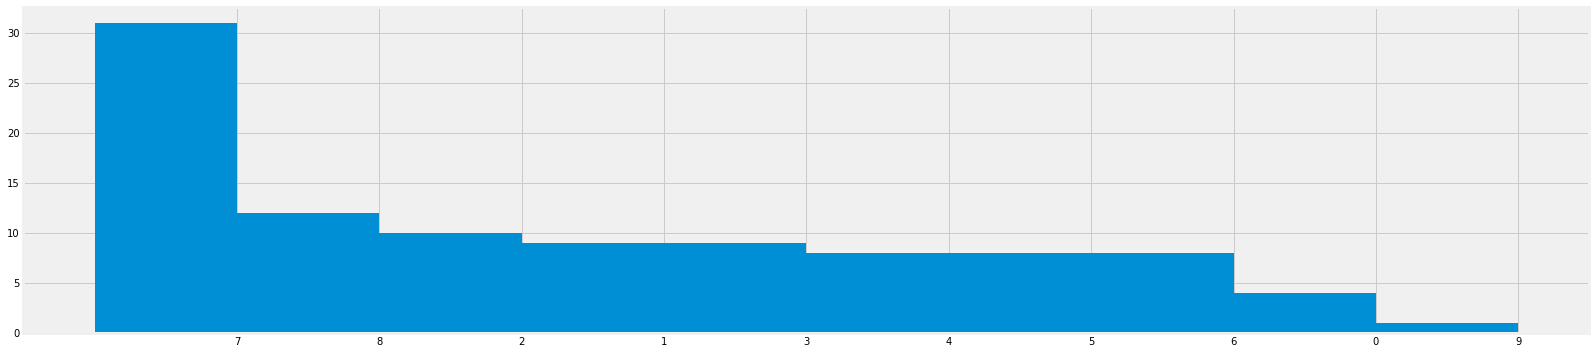

In [57]:
n_top_words = 5

tf_feature_names = tf_vectorizer.get_feature_names()
# for model in models:
top_words = get_top_words(model, tf_feature_names, n_top_words)
for topic_idx, words in enumerate(top_words):
    print("Topic #{}: {}".format(topic_idx, words))
sizes = get_doc_counts_per_topic(bodies, model, tf_vectorizer, hard_clustering=True)
plot_doc_counts(sizes)

In [58]:
topic_df = pd.DataFrame({"Key terms": top_words,
                        "Size": [val for _, val in sorted(sizes.items())]})
topic_df

,Key terms,Size
0,new scsicontroller cve vcan powercli,4
1,vcenter problem host vmware alerts,9
2,error failed connect process peer,10
3,esxi host lost version firmware,9
4,host stores cluster data dvs,8
5,cluster server error dc vmfs,8
6,vcenter vrealize host update assistance,8
7,server vcenter com psc appliance,31
8,vm disk host network hosts,12
9,05 level 12pm investigate customer,1


For each query, the following will determine which topic(s) that query belongs in and add that query to a list in the `topic_df`.

In [59]:
from collections import defaultdict
query_topics = []
query_scores = []
topic_bodies = defaultdict(lambda: [])
for body in bodies:
    topic, scores = get_top_topics(body, model, tf_vectorizer, hard_clustering=True)
    query_topics.append(topic[0])
    query_scores.append(scores[0])
    topic_bodies[topic[0]].append(body)
#     print("{}: {}".format(topic[0], body[:50]))
    
print("Length of query_topics: {}".format(len(query_topics)))
print("Length of query_scores: {}".format(len(query_scores)))
print("Length of corpus_df:    {}".format(len(corpus_df)))
corpus_df["Topic ID"] = query_topics
corpus_df["Score"] = query_scores

pd.set_option('display.height', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_colwidth', -1)
corpus_df = corpus_df.sort_values(['Topic ID', 'Score'], ascending=[True, False])
corpus_df

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100


,body,session_id,Topic ID,Score
8,"When configuring a Platform Services Controller (appliance), final configuration stopped with error: Failed to run vdcpromo\n\nSSO configuration: joined existing SSO domain euc.chorus.co.nz, new site called chorus-hlz (multisite architecture, not HA)\n\nExisting (running) PSC: vcan-a03-euc-psc019.vcan.local, 10.107.53.19\nNew PSC (failed config): vcan-h00-euc-psc019.vcan.local, 10.108.53.19\n\nI have download the log bundle and will upload this to the FTP site",6eded09c-f65c-44fb-afe7-37e177798230,0,0.305942
40,"PowerCLI limitation with New-ScsiController\n\nThe PowerCLI command New-ScsiController doesn't work if the VM is powered on. However, a new SCSI controller can be added to a powered on VM using the web UI. Why doesn't this work in PowerCLI?\n\nVersion:\nVMware PowerCLI 6.5 Release 1 build 4624819\n\nHere is the error:\n\nNew-ScsiController -Type ParaVirtual -Confirm:$false -HardDisk $disk\n\nNew-ScsiController : 5/9/2018 4:22:24 PM\tNew-ScsiController\t\tThe VM must be in the following state: PoweredOff.",2e0252b3-f940-44e1-9f78-7bc5a298a92a,0,0.262250
72,configuring BGP routing Thursday at 18:00 PST need an SA if run into issues Preemptive,d7dc8f47-4779-4cbd-b752-daf441d52b33,0,0.149882
88,"cve-2017-4902, cve-2017-4903, cve-2017-4904, cve-2017-4095",26558d14-6988-4061-8905-3914d3e6b362,0,0.123006
7,"We have VM host failed last night with a purple screen. It showed at the last two lines ""FileDump: FAILED: Couldn't dump header: 0xbad0001. No port for remote debugger. ""Escape"" for local debugger""\nI have contracted Dell hardware support. They couldn't find problem from hardware side. They suggested to contract VMWare for OS problem. Please help us investigate the problem on this VM host.",24ced1d1-e6f5-4259-8087-8cbd3507f57f,1,0.252178
11,"We have a license alert for a vCenter that is no longer in the SSO. During a previous supprort session, they found a stale vCenter entry for the old vCenter no longer around. It was a part of the SSO originally and removed.\n\nPrevious support engineer was able to find the stale entry in JXplorer but we were working on another change and requested we open another ticket to fix this issue. Attaching screenshot showing stale entry that needs to be removed.",a3f2333b-fe69-42fd-9a25-c9fc1a1b5213,1,0.228949
23,"we experience disconnection from the network, our phone system was down for about 15 mins, after a call with our phone vendor the connection was re-establish. We still experienced hiccups, but we think is on the VM side, I pulled the VMware logs from the host",cd0e58d3-72b6-41cf-9949-0e4bcf02a22b,1,0.183761
94,We would like to setup Veeam Replica to Dell internal drive drive. Have VMWare 6.5 on SDCard. Is this possible? Can we setup datastore in VMWare and shared the datastore to other ESXi host? Thanks.,1fdcb312-17f6-426d-b1b9-cb1ed0161163,1,0.181317
25,"All four hosts in our vSAN cluster lost access to ""volumes"" between 12:21am and 12:23am last night resulting in a a slew of alerts from our monitoring system reporting various virtual machines down.",bc4f8536-06c1-4a20-a423-44e788475a1a,1,0.178087
35,"Having trouble copying a Windows ISO file to the datastore in 6.7 environment, performing the same steps in 6.5 environment with no problem",7fca2c5e-f210-4dbe-8e00-ce2ffef39db0,1,0.155623


The key terms may never give us enough insight into the actual underlying issue(s) behind the queries in that topic. One possible way to get that finer detail is to look at the n-grams that are unique to each topic.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_top_n_grams(documents, n, top_n):
    try:
        tfidf_vect = TfidfVectorizer(ngram_range=(n,n))
        n_grams = tfidf_vect.fit_transform(documents)

        vocab = tfidf_vect.vocabulary_
        count_values = n_grams.toarray().sum(axis=0)
        counts = sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)

        return [word for (score, word) in counts[:top_n]]
    except:
        return []

In [61]:
# topic_bodies
top_1_grams = []
top_2_grams = []
top_3_grams = []
for topic, topic_body in topic_bodies.items():
    top_1_grams.append(get_top_n_grams(topic_body, 1, 5))
    top_2_grams.append(get_top_n_grams(topic_body, 2, 5))
    top_3_grams.append(get_top_n_grams(topic_body, 3, 5))
    
topic_df["Top 1-grams"] = top_1_grams
topic_df["Top 2-grams"] = top_2_grams
topic_df["Top 3-grams"] = top_3_grams
topic_df

,Key terms,Size,Top 1-grams,Top 2-grams,Top 3-grams
0,new scsicontroller cve vcan powercli,4,"[cve, 2017, the, new, scsicontroller]","[cve 2017, new scsicontroller, thursday at, sa if, run into]","[cve 2017 4904, cve 2017 4903, cve 2017 4902, cve 2017 4095, 4904 cve 2017]"
1,vcenter problem host vmware alerts,9,"[the, problem, we, in, with]","[with powercli, problem with, went down, vms went, random vms]","[problem with powercli, vms went down, random vms went, with no problem, windows iso file]"
2,error failed connect process peer,10,"[error, to, search, failed, the]","[installing nsx, error code, esxupdate error, code 15, failed to]","[esxupdate error code, error code 15, storage and now, now can reconnect, lost fiber storage]"
3,esxi host lost version firmware,9,"[esxi, the, host, of, to]","[of esxi, client is, prevents migration, esxi prevents, crash of]","[of esxi prevents, esxi prevents migration, crash of esxi, cannot connect host, vms from multiple]"
4,host stores cluster data dvs,8,"[the, to, not, host, web]","[web client, is not, not working, client is, data stores]","[web client is, is not working, client is not, visible in web, v6 plugins not]"
5,cluster server error dc vmfs,8,"[the, to, hosts, on, cluster]","[unable to, the snapshot, to consolidate, snapshot lockout, lockout error]","[unable to consolidate, to consolidate the, the snapshot lockout, snapshot lockout error, consolidate the snapshot]"
6,vcenter vrealize host update assistance,8,"[certificate, we, update, to, need]","[update certificate, with identifier, or filesystem, filesystem with, device or]","[or filesystem with, filesystem with identifier, device or filesystem, vpn traffic dropping, traffic dropping for]"
7,server vcenter com psc appliance,31,"[the, to, server, vcenter, update]","[vcenter server, server appliance, appliance update, the vcenter, health alarm]","[vcenter server appliance, server appliance update, vcsa to 5u1g, upgrade vcsa to, update update fails]"
8,vm disk host network hosts,12,"[the, to, vm, remove, network]","[remove vm, unable to, vm freezes, freezes during, during vmotion]","[vm freezes during, freezes during vmotion, unable to add, to add hard, hard disk to]"
9,05 level 12pm investigate customer,1,"[we, to, from, at, 12pm]","[zone vm, we had, we cannot, was completely, vsphere logs]","[zone vm was, we had to, we cannot find, was completely crashed, vsphere logs please]"


And finally, to find the actual context in which the key terms appear within the documents of the topic, we'll create a CountVector where the value is `1` for each of the key terms and then find the dot product of that vector with the CountVectors from all of the bodies within that topic.

In [36]:
import numpy as np
topic_scores = defaultdict(lambda: [])

best_sentences = {}
for idx in range(num_topics):
    best_sentences[idx] = ""
for topic_idx in range(num_topics):
    try: 
        best_sentences[topic_idx] = find_best_sentence(corpus_df[corpus_df["Topic ID"] == topic_idx]["body"].tolist(),
                                                       topic_df.iloc[topic_idx]["Key terms"])
    except Exception as err:
        print("Failed for topic {}: {}".format(topic_idx, err))
    
topic_df["Best sentence"] = best_sentences.values()
topic_df

,Key terms,Size,Top 1-grams,Top 2-grams,Top 3-grams,Best sentence
0,new scsicontroller cve vcan powercli,4,"[cve, 2017, the, new, scsicontroller]","[cve 2017, new scsicontroller, thursday at, sa if, run into]","[cve 2017 4904, cve 2017 4903, cve 2017 4902, cve 2017 4095, 4904 cve 2017]","cve-2017-4902, cve-2017-4903, cve-2017-4904, cve-2017-4095"
1,vcenter problem host vmware alerts,9,"[the, problem, we, in, with]","[with powercli, problem with, went down, vms went, random vms]","[problem with powercli, vms went down, random vms went, with no problem, windows iso file]","We still experienced hiccups, but we think is on the VM side, I pulled the VMware logs from the host"
2,error failed connect process peer,10,"[error, to, search, failed, the]","[installing nsx, error code, esxupdate error, code 15, failed to]","[esxupdate error code, error code 15, storage and now, now can reconnect, lost fiber storage]",installing NSX 6.4.0
3,esxi host lost version firmware,9,"[esxi, the, host, of, to]","[of esxi, client is, prevents migration, esxi prevents, crash of]","[of esxi prevents, esxi prevents migration, crash of esxi, cannot connect host, vms from multiple]",I am working through a Firmware update process for my Dell R360 host running ESXi 6.5 U1.
4,host stores cluster data dvs,8,"[the, to, not, host, web]","[web client, is not, not working, client is, data stores]","[web client is, is not working, client is not, visible in web, v6 plugins not]","I have tried re-scanning for the data stores from the VCSA, the WebCleint, and directly from the host."
5,cluster server error dc vmfs,8,"[the, to, hosts, on, cluster]","[unable to, the snapshot, to consolidate, snapshot lockout, lockout error]","[unable to consolidate, to consolidate the, the snapshot lockout, snapshot lockout error, consolidate the snapshot]",We experience occasional heartbeat failures on a Microsoft Windows Server Foundation Cluster WSFC two node cluster.
6,vcenter host vrealize update network,9,"[certificate, we, update, on, network]","[update certificate, with identifier, or filesystem, filesystem with, device or]","[or filesystem with, filesystem with identifier, device or filesystem, vpn traffic dropping, traffic dropping for]",the license is for 2 CPU and we have a 2 CPU host on it but in vRealize it says we are oversubscribed with 6 CPUs and gives an invalid license error on certain pages in vRealize.
7,server vcenter com psc appliance,31,"[the, to, server, vcenter, update]","[vcenter server, server appliance, appliance update, the vcenter, health alarm]","[vcenter server appliance, server appliance update, vcsa to 5u1g, upgrade vcsa to, update update fails]",Can we migrate from vCenter Server on Windows with an external SSO to an appliance with internal PSC?
8,vm disk host network hosts,11,"[the, to, vm, remove, disk]","[remove vm, unable to, vm freezes, freezes during, during vmotion]","[vm freezes during, freezes during vmotion, unable to add, to add hard, hard disk to]","After cloning a vm, Network in Network Adapter of the new VM summary page displays the original Network instead of the a new Network selected and applied in Settings."
9,05 level 12pm investigate customer,1,"[we, to, from, at, 12pm]","[zone vm, we had, we cannot, was completely, vsphere logs]","[zone vm was, we had to, we cannot find, was completely crashed, vsphere logs please]","Customer is reporting storage errors at OS level, we cannot find anything from vsphere logs."


In [45]:
corpus_df = corpus_df[["Topic ID", "Score", "session_id", "body"]]
corpus_df.to_csv("../results/last-week-10-topics/documents-LDA.csv", index=False)
topic_df.index.name = 'Topic ID'
topic_df.to_csv("../results/last-week-10-topics/topics-LDA.csv")

## Experiment

And now I'll create one body of code that wraps this all together to make it easier to run the analysis on different datasets and varying number of topics.

### Vmware-last-week corpus

Total number of queries: 100
-----------------------------------------------------
Running analysis on last-week for 10 topics
-----------------------------------------------------
Number of features: 1026
Topic #0: update firmware process version connect
Topic #1: guest stale cluster issue smtp
Topic #2: vrealize network dvs tried getting
Topic #3: vcan psc lost connectivity euc
Topic #4: disk data stores free shows
Topic #5: appliance vsphere update alarm network
Topic #6: pscs servers consolidate 2018 creating
Topic #7: com dns systemd psc resolved
Topic #8: https cluster dc backup 2017
Topic #9: ldap invalid code site interop


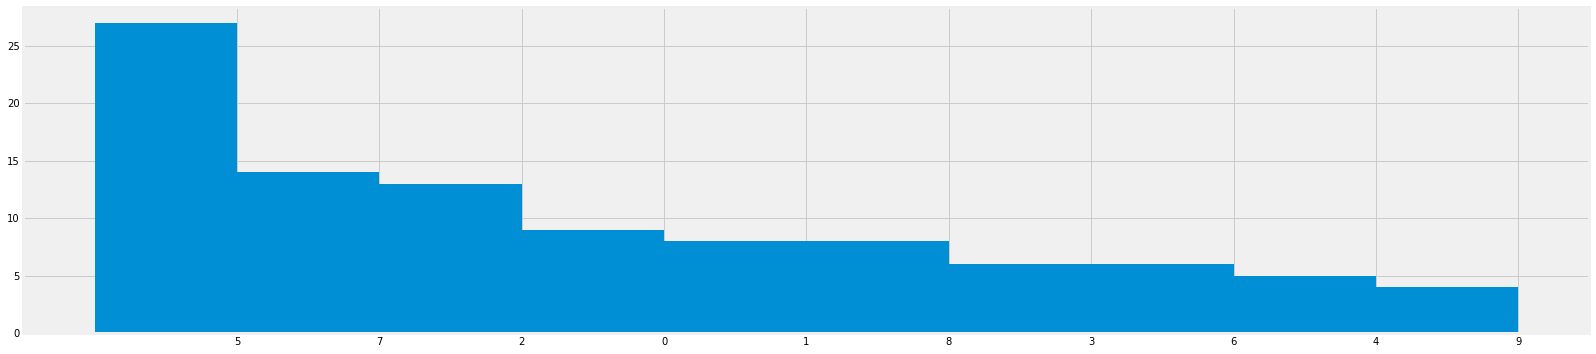

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100
-----------------------------------------------------
Running analysis on last-week for 25 topics
-----------------------------------------------------
Number of features: 1026
Topic #0: update version vca longer vtpm
Topic #1: pst prevents additional rhel6 removed
Topic #2: setup datastore need drive adapter
Topic #3: alerts smtp email setting vmotion
Topic #4: disk free space guest equallogic
Topic #5: appliance vsphere update alarm sso
Topic #6: consolidate 500 disabling status http
Topic #7: update running firmware appliance external
Topic #8: cluster 2017 cve stores data
Topic #9: phone 15 migration esxupdate mins
Topic #10: psc vcsa ran services appliances
Topic #11: changing ip established vcsa response
Topic #12: environment having windows installing problem
Topic #13: tried doesn 764efe06 target 21am
Topic #14: dvs sync machine delete device
Topic #15: network new issue file upgrade
Topic #16: 

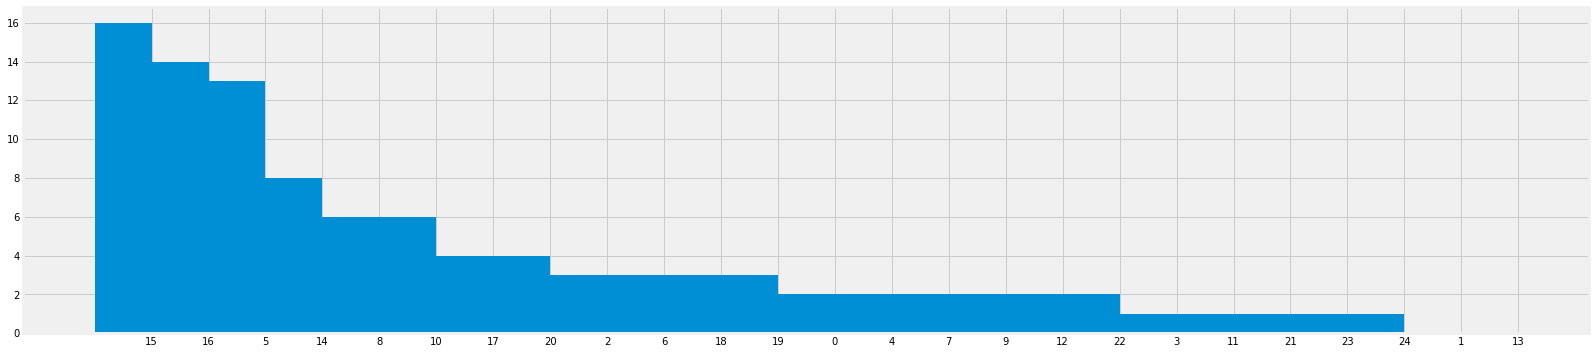

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100
Failed for topic 1: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 13: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 21: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 24: empty vocabulary; perhaps the documents only contain stop words
-----------------------------------------------------
Running analysis on last-week for 50 topics
-----------------------------------------------------
Number of features: 1026
Topic #0: datastore software thursday flash vms
Topic #1: stale entry removed longer sso
Topic #2: attachment booting red screen ftp
Topic #3: vmotion xxx received mode disk
Topic #4: disk free space guest rdm
Topic #5: appliance update sso psc external
Topic #6: consolidate zeroes mar mspmxapps280 engineering
Topic #7: firewall rule need reboots running
Topic #8: visible pscs doc notices contract

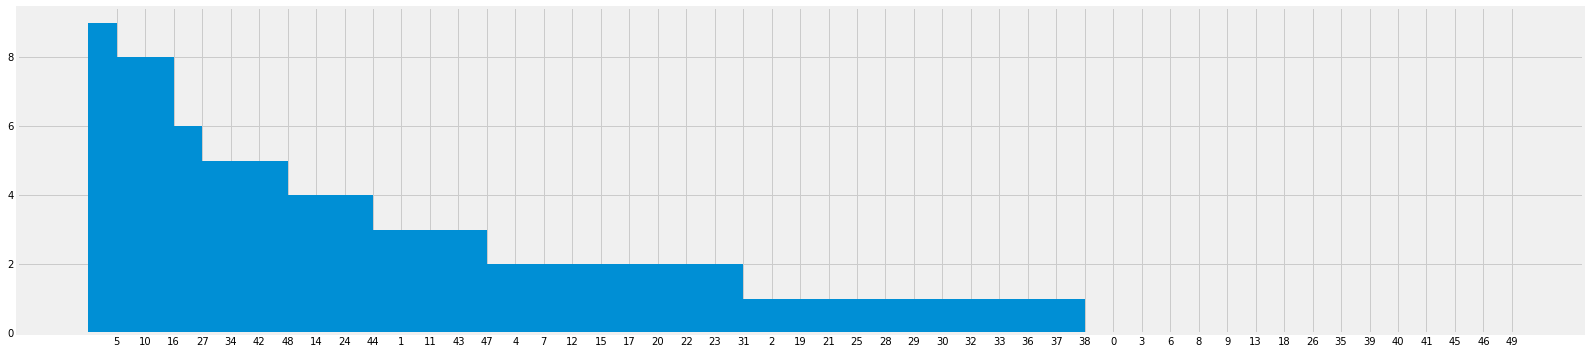

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100
Failed for topic 0: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 3: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 8: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 9: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 13: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 18: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 21: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 23: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 26: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 28: empty vocabulary; perhaps the documents only conta

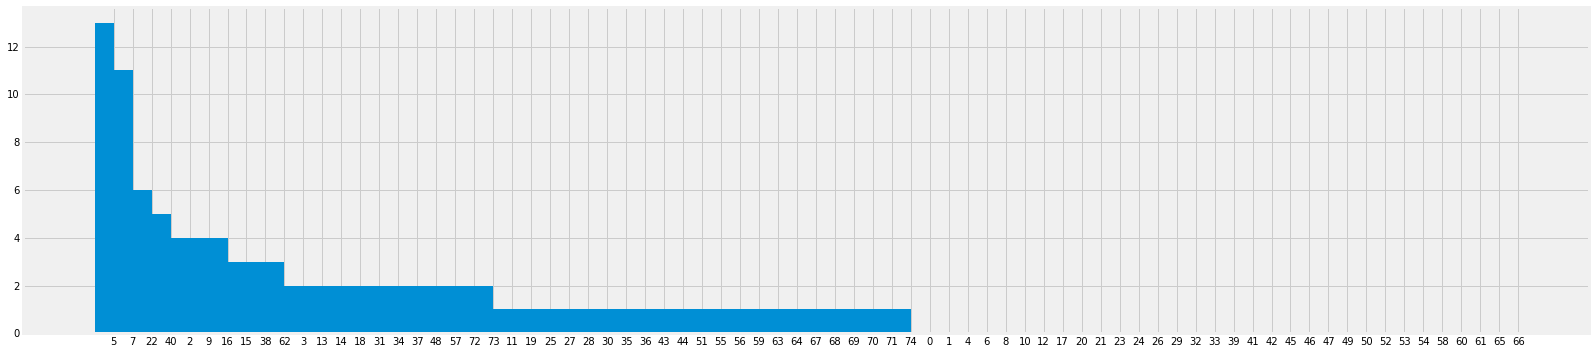

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100
Failed for topic 0: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 1: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 4: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 8: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 10: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 12: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 17: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 20: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 21: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 23: empty vocabulary; perhaps the documents only conta

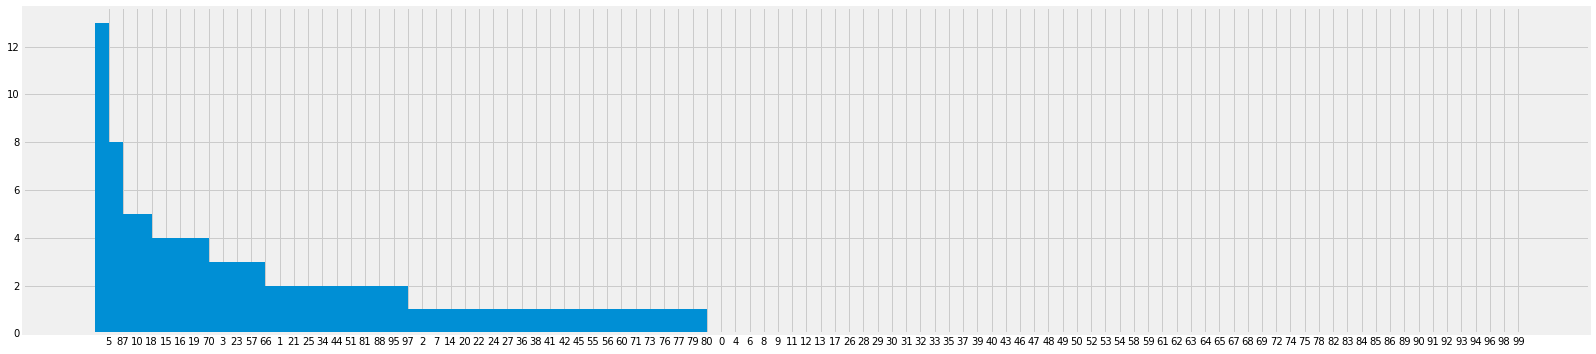

Length of query_topics: 100
Length of query_scores: 100
Length of corpus_df:    100
Failed for topic 0: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 4: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 8: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 9: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 11: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 12: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 13: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 17: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 26: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 28: empty vocabulary; perhaps the documents only conta

In [68]:
corpus_suffix = "last-week"
corpus = corpora.load("../corpora/vmware-"+corpus_suffix)

# convert the list of Search objects into a dataframe
corpus_df = pd.DataFrame([vars(c) for c in corpus])
print("Total number of queries: {}".format(len(corpus_df)))

# For our current purposes, the timestamp isn't needed
corpus_df = corpus_df.drop(columns=["timestamp"])
corpus_df.head()

# n_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.10, min_df=1,
#                                 max_features=n_features,
                                stop_words='english'
                               )
# create a list of just the bodies
bodies = [c.body for c in corpus]
tf = tf_vectorizer.fit_transform(bodies)

num_topics_list = [10, 25, 50, 75, 100]

for num_topics in num_topics_list:
    print("-----------------------------------------------------")
    print("Running analysis on {} for {} topics".format(corpus_suffix, num_topics))
    print("-----------------------------------------------------")
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0,
                                    n_jobs=-1,
                                   )
    lda.fit(tf)
    model = lda
    print("Number of features: {}".format(len(model.components_[0])))

    n_top_words = 5

    tf_feature_names = tf_vectorizer.get_feature_names()

    top_words = get_top_words(model, tf_feature_names, n_top_words)
    for topic_idx, words in enumerate(top_words):
        print("Topic #{}: {}".format(topic_idx, words))
    sizes = get_doc_counts_per_topic(bodies, model, tf_vectorizer, hard_clustering=True)
    plot_doc_counts(sizes)

    #create topic_df
    topic_df = pd.DataFrame({"Key terms": top_words,
                            "Size": [val for _, val in sorted(sizes.items())]})

    # create corpus_df
    from collections import defaultdict
    query_topics = []
    query_scores = []
    topic_bodies = {}
    for idx in range(num_topics):
        topic_bodies[idx] = []
    for body in bodies:
        topic, scores = get_top_topics(body, model, tf_vectorizer, hard_clustering=True)
        query_topics.append(topic[0])
        query_scores.append(scores[0])
        topic_bodies[topic[0]].append(body)

    print("Length of query_topics: {}".format(len(query_topics)))
    print("Length of query_scores: {}".format(len(query_scores)))
    print("Length of corpus_df:    {}".format(len(corpus_df)))
    corpus_df["Topic ID"] = query_topics
    corpus_df["Score"] = query_scores

    pd.set_option('display.height', 75)
    pd.set_option('display.max_rows', 75)
    pd.set_option('display.max_colwidth', -1)
    corpus_df = corpus_df.sort_values(['Topic ID', 'Score'], ascending=[True, False])
    corpus_df

    # get top n grams
    top_1_grams = []
    top_2_grams = []
    top_3_grams = []
    for topic, topic_body in topic_bodies.items():
        top_1_grams.append(get_top_n_grams(topic_body, 1, 5))
        top_2_grams.append(get_top_n_grams(topic_body, 2, 5))
        top_3_grams.append(get_top_n_grams(topic_body, 3, 5))
    
    topic_df["Top 1-grams"] = top_1_grams
    topic_df["Top 2-grams"] = top_2_grams
    topic_df["Top 3-grams"] = top_3_grams
    topic_df

    #get best sentence
    topic_scores = defaultdict(lambda: [])

    best_sentences = {}
    for idx in range(num_topics):
        best_sentences[idx] = ""
    for topic_idx in range(num_topics):
        try: 
            best_sentences[topic_idx] = find_best_sentence(corpus_df[corpus_df["Topic ID"] == topic_idx]["body"].tolist(),
                                                           topic_df.iloc[topic_idx]["Key terms"])
        except Exception as err:
            print("Failed for topic {}: {}".format(topic_idx, err))

    topic_df["Best sentence"] = best_sentences.values()

    #save
    corpus_df = corpus_df[["Topic ID", "Score", "session_id", "body"]]
    corpus_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/documents-LDA.csv", index=False)
    topic_df.index.name = 'Topic ID'
    topic_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/topics-LDA.csv")

### Vmware-last-month corpus

Total number of queries: 7158
-----------------------------------------------------
Running analysis on last-month for 10 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: service connect failed start responding
Topic #1: file storage snapshot failed datastore
Topic #2: version upgrade cluster vsan running
Topic #3: root 10 logs 01 mode
Topic #4: virtual disk cluster datastore storage
Topic #5: 2018 04 failed 00 warning
Topic #6: network nsx port switch lost
Topic #7: psod org inventory vcloud 0x0
Topic #8: client vsphere com web manager
Topic #9: ha vsphere certificate alarm site


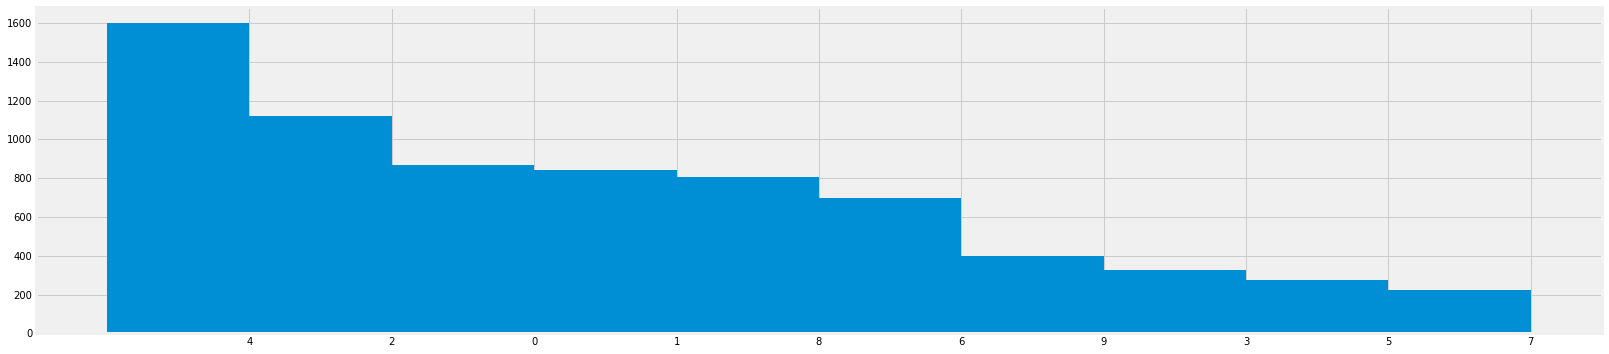

Length of query_topics: 7158
Length of query_scores: 7158
Length of corpus_df:    7158
-----------------------------------------------------
Running analysis on last-month for 25 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: vcsa java psc site appliance
Topic #1: storage fails sr cve enable
Topic #2: management domain password active appliance
Topic #3: 16489371 permissions folder sfcbd 54z
Topic #4: virtual machine file failed disk
Topic #5: space disk storage event vmfs
Topic #6: network nsx port switch cisco
Topic #7: screen psod crashed purple crash
Topic #8: backup guest vim fault failing
Topic #9: certificate ssl 0x0 reported download
Topic #10: log upgrade esx manager update
Topic #11: com kb https article agent
Topic #12: snapshot create task id invalid
Topic #13: 2018 04 00 10 13
Topic #14: storage datastore lost connectivity device
Topic #15: unable add disk datastore operation
Topic #16: view help able connection environment


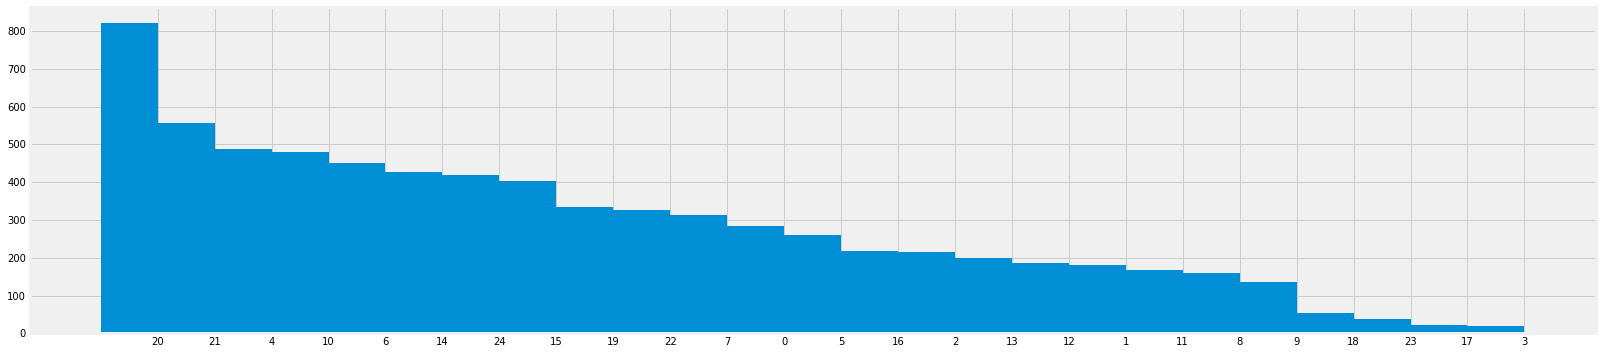

Length of query_topics: 7158
Length of query_scores: 7158
Length of corpus_df:    7158
-----------------------------------------------------
Running analysis on last-month for 50 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: psod descriptor successfully unknown having
Topic #1: sr result requested browser snapshot
Topic #2: vcsa new psc old deployed
Topic #3: root apr 56 command stuck
Topic #4: showing domain active controller sso
Topic #5: production environment hostd ac vpxa
Topic #6: hang resolve san looking 27
Topic #7: upgrade version update esx build
Topic #8: managed starting io page 48
Topic #9: nsx migration connection manager failed
Topic #10: 10 2018 04 00 12
Topic #11: com vsphere client www http
Topic #12: 38 12t05 vmnic8 queue disabling
Topic #13: service java failed vpxd http
Topic #14: device boot type naa local
Topic #15: start services restart service vim
Topic #16: vmfs volumes open tools event
Topic #17: com kb https

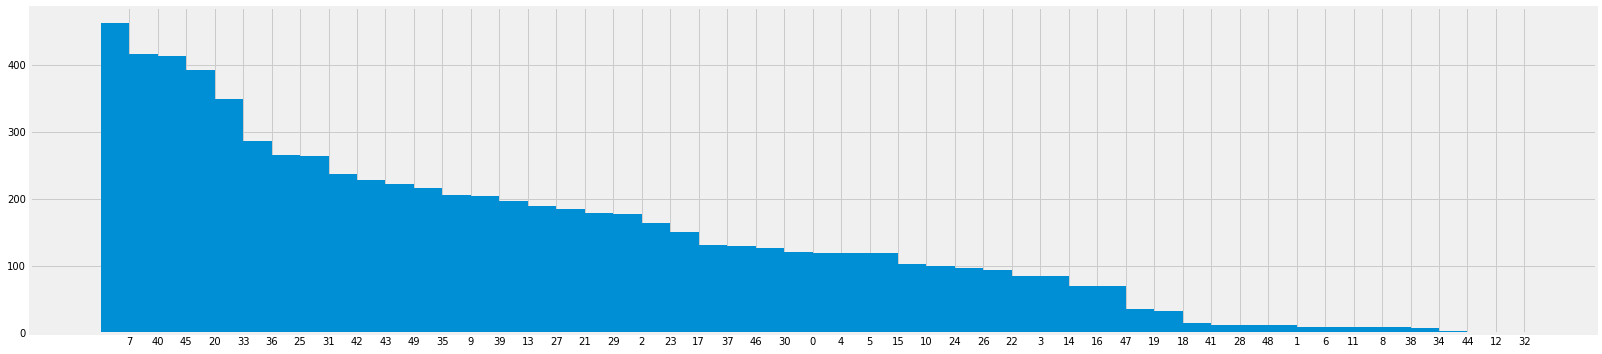

Length of query_topics: 7158
Length of query_scores: 7158
Length of corpus_df:    7158
Failed for topic 12: empty vocabulary; perhaps the documents only contain stop words
-----------------------------------------------------
Running analysis on last-month for 75 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: assistance provide kindly regarding like
Topic #1: unresponsive connections situation possible 25
Topic #2: backup guest snapshot failing application
Topic #3: specified property goes bundle longer
Topic #4: virtual machine machines servers production
Topic #5: cause logs help know psod
Topic #6: memory high cpu capacity reporting
Topic #7: packet payload 26 passivemonitor 6876
Topic #8: managed starting io page 48
Topic #9: data size solution increase store
Topic #10: esx vcsa upgrade agent sites
Topic #11: view 0x0 configuration horizon vdi
Topic #12: 13t11 16489371 sfcbd understand doesn
Topic #13: vsan root cve 2017 logged
Topic

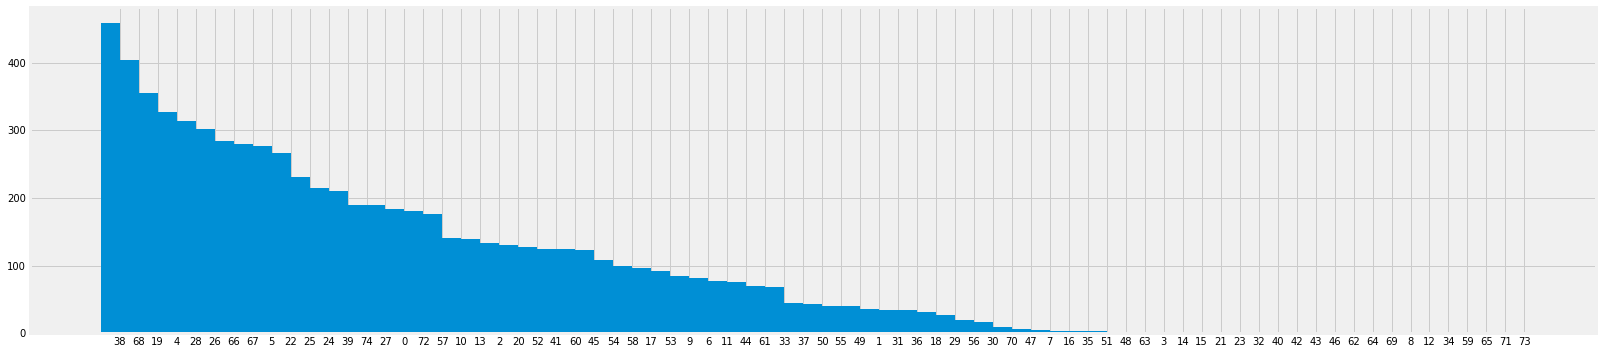

Length of query_topics: 7158
Length of query_scores: 7158
Length of corpus_df:    7158
Failed for topic 3: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 8: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 12: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 14: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 34: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 59: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 64: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 65: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 71: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 73: empty vocabulary; perhaps the documents only contain stop words
-----------------------------------------------------
Running ana

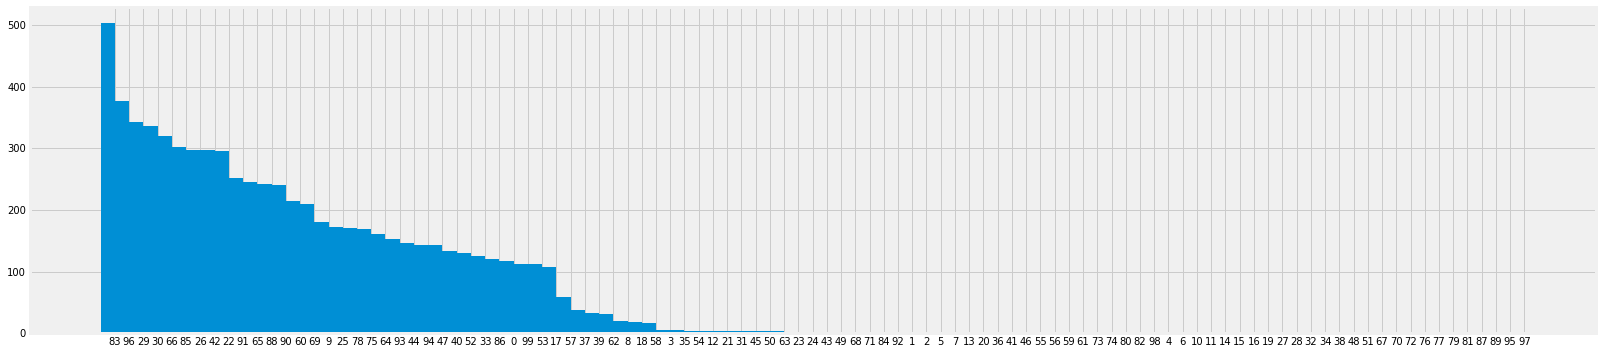

Length of query_topics: 7158
Length of query_scores: 7158
Length of corpus_df:    7158
Failed for topic 4: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 5: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 10: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 11: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 14: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 15: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 16: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 19: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 27: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 28: empty vocabulary; perhaps the documents only 

In [69]:
corpus_suffix = "last-month"
corpus = corpora.load("../corpora/vmware-"+corpus_suffix)

# convert the list of Search objects into a dataframe
corpus_df = pd.DataFrame([vars(c) for c in corpus])
print("Total number of queries: {}".format(len(corpus_df)))

# For our current purposes, the timestamp isn't needed
corpus_df = corpus_df.drop(columns=["timestamp"])
corpus_df.head()

n_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.10, min_df=1,
                                max_features=n_features,
                                stop_words='english'
                               )
# create a list of just the bodies
bodies = [c.body for c in corpus]
tf = tf_vectorizer.fit_transform(bodies)

num_topics_list = [10, 25, 50, 75, 100]

for num_topics in num_topics_list:
    print("-----------------------------------------------------")
    print("Running analysis on {} for {} topics".format(corpus_suffix, num_topics))
    print("-----------------------------------------------------")
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0,
                                    n_jobs=-1,
                                   )
    lda.fit(tf)
    model = lda
    print("Number of features: {}".format(len(model.components_[0])))

    n_top_words = 5

    tf_feature_names = tf_vectorizer.get_feature_names()

    top_words = get_top_words(model, tf_feature_names, n_top_words)
    for topic_idx, words in enumerate(top_words):
        print("Topic #{}: {}".format(topic_idx, words))
    sizes = get_doc_counts_per_topic(bodies, model, tf_vectorizer, hard_clustering=True)
    plot_doc_counts(sizes)

    #create topic_df
    topic_df = pd.DataFrame({"Key terms": top_words,
                            "Size": [val for _, val in sorted(sizes.items())]})

    # create corpus_df
    from collections import defaultdict
    query_topics = []
    query_scores = []
    topic_bodies = {}
    for idx in range(num_topics):
        topic_bodies[idx] = []
    for body in bodies:
        topic, scores = get_top_topics(body, model, tf_vectorizer, hard_clustering=True)
        query_topics.append(topic[0])
        query_scores.append(scores[0])
        topic_bodies[topic[0]].append(body)

    print("Length of query_topics: {}".format(len(query_topics)))
    print("Length of query_scores: {}".format(len(query_scores)))
    print("Length of corpus_df:    {}".format(len(corpus_df)))
    corpus_df["Topic ID"] = query_topics
    corpus_df["Score"] = query_scores

    pd.set_option('display.height', 75)
    pd.set_option('display.max_rows', 75)
    pd.set_option('display.max_colwidth', -1)
    corpus_df = corpus_df.sort_values(['Topic ID', 'Score'], ascending=[True, False])
    corpus_df

    # get top n grams
    top_1_grams = []
    top_2_grams = []
    top_3_grams = []
    for topic, topic_body in topic_bodies.items():
        top_1_grams.append(get_top_n_grams(topic_body, 1, 5))
        top_2_grams.append(get_top_n_grams(topic_body, 2, 5))
        top_3_grams.append(get_top_n_grams(topic_body, 3, 5))
    
    topic_df["Top 1-grams"] = top_1_grams
    topic_df["Top 2-grams"] = top_2_grams
    topic_df["Top 3-grams"] = top_3_grams
    topic_df

    #get best sentence
    topic_scores = defaultdict(lambda: [])

    best_sentences = {}
    for idx in range(num_topics):
        best_sentences[idx] = ""
    for topic_idx in range(num_topics):
        try: 
            best_sentences[topic_idx] = find_best_sentence(corpus_df[corpus_df["Topic ID"] == topic_idx]["body"].tolist(),
                                                           topic_df.iloc[topic_idx]["Key terms"])
        except Exception as err:
            print("Failed for topic {}: {}".format(topic_idx, err))

    topic_df["Best sentence"] = best_sentences.values()

    #save
    corpus_df = corpus_df[["Topic ID", "Score", "session_id", "body"]]
    corpus_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/documents-LDA.csv", index=False)
    topic_df.index.name = 'Topic ID'
    topic_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/topics-LDA.csv")

### Vsphere-6.5-last-month corpus

Total number of queries: 1494
-----------------------------------------------------
Running analysis on vsphere-6.5-last-month for 10 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: vsphere service upgrade appliance failed
Topic #1: cluster vsan kb article com
Topic #2: 2018 04 file failed machine
Topic #3: network vms vmotion storage switch
Topic #4: 00 screen 12 purple 04
Topic #5: cluster vcsa issues new virtual
Topic #6: test tools upgrade vcenters ovf
Topic #7: java org springframework servlet web
Topic #8: disk storage space device data
Topic #9: datastore active license size node


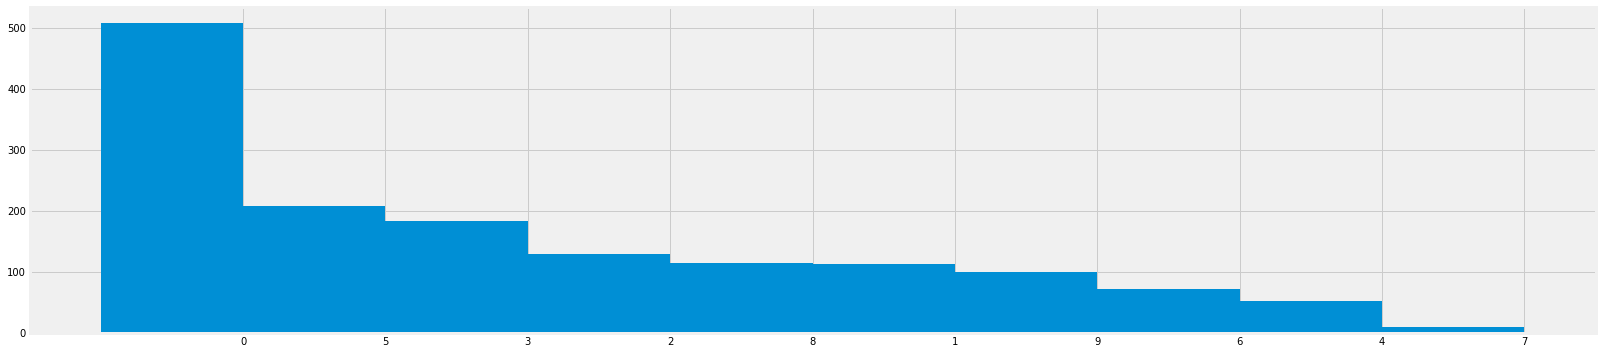

Length of query_topics: 1494
Length of query_scores: 1494
Length of corpus_df:    1494
-----------------------------------------------------
Running analysis on vsphere-6.5-last-month for 25 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: service vpxd failed http endpoint
Topic #1: responding vpxa state hung hostd
Topic #2: kb com update article https
Topic #3: esdgtctp35101v apr kernel 08 reconnect
Topic #4: switch distributed licenses standard licensing
Topic #5: vms storage network issues cluster
Topic #6: java org web springframework servlet
Topic #7: replication network card vmdk does
Topic #8: emc array port ok box
Topic #9: disk test hdd space gb
Topic #10: new domain psc certificate port
Topic #11: rename folders folder parent allowed
Topic #12: cluster machine virtual vsan cpu
Topic #13: crashed size servers database day
Topic #14: hostname certificate change match ip
Topic #15: vsphere client appliance vcsa web
Topic #16: 0x0 sc

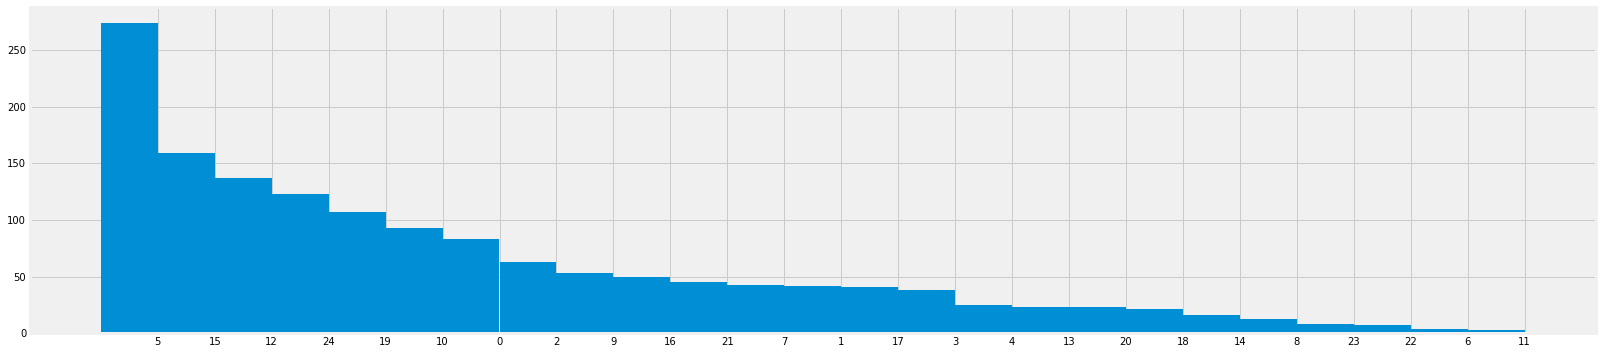

Length of query_topics: 1494
Length of query_scores: 1494
Length of corpus_df:    1494
-----------------------------------------------------
Running analysis on vsphere-6.5-last-month for 50 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: showing unavailable service 503 dear
Topic #1: resolved related bnx2x similar security
Topic #2: occurred single sign sending authentication
Topic #3: software port firmware booted licenses
Topic #4: 35 adapter dns lock result
Topic #5: 00 enable 23 29 missing
Topic #6: frameworkservlet replication retrieve like 23
Topic #7: card network change address mac
Topic #8: logs standalone info object 49
Topic #9: false controller vcenters sas raid
Topic #10: having disks usb increase properly
Topic #11: java springframework servlet web method
Topic #12: licensing size option available thanks
Topic #13: switch distributed ping failing happening
Topic #14: migration control space retry spectre
Topic #15: attempti

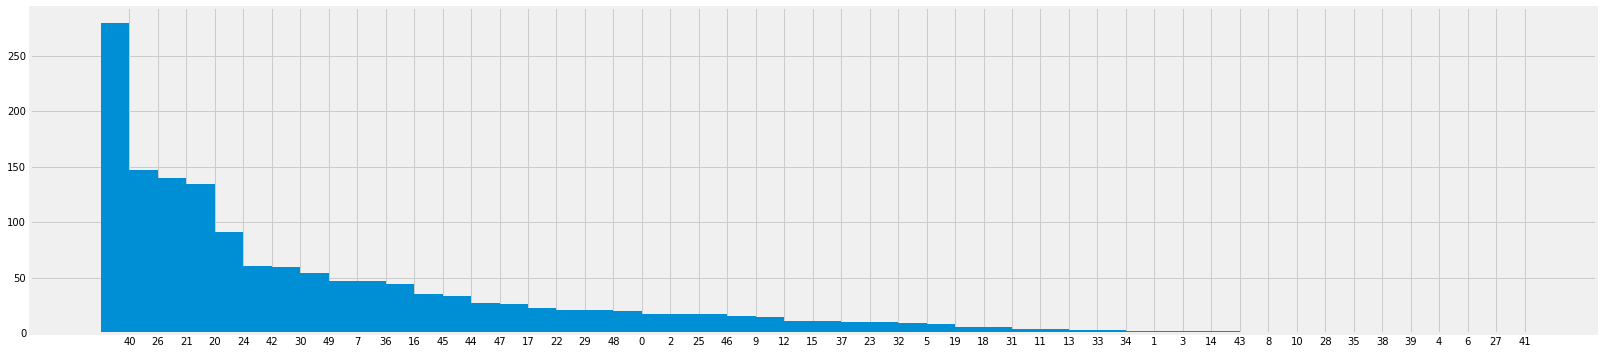

Length of query_topics: 1494
Length of query_scores: 1494
Length of corpus_df:    1494
Failed for topic 4: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 27: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 41: empty vocabulary; perhaps the documents only contain stop words
-----------------------------------------------------
Running analysis on vsphere-6.5-last-month for 75 topics
-----------------------------------------------------
Number of features: 1000
Topic #0: org com java http springframework
Topic #1: resolved related bnx2x similar security
Topic #2: try update receive hi appliance
Topic #3: cluster vsan kb com machine
Topic #4: license connecting licenses licensing iscsi
Topic #5: enable 00 trying 23 29
Topic #6: corrupted 11 production volume frameworkservlet
Topic #7: card updates subnet non switches
Topic #8: logs standalo

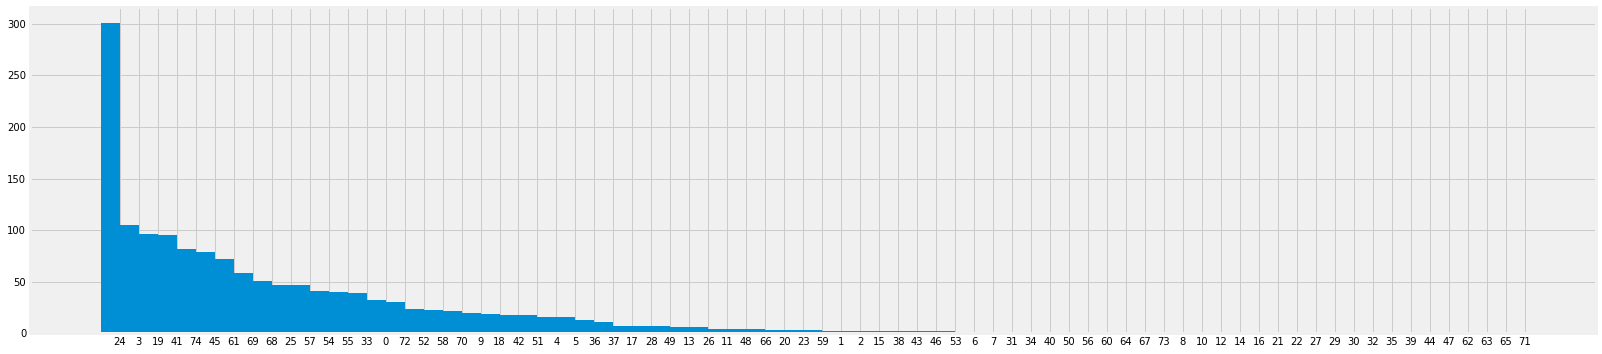

Length of query_topics: 1494
Length of query_scores: 1494
Length of corpus_df:    1494
Failed for topic 7: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 8: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 10: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 12: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 14: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 16: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 21: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 22: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 27: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 29: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 30: empty vocabulary; perhaps the documents only

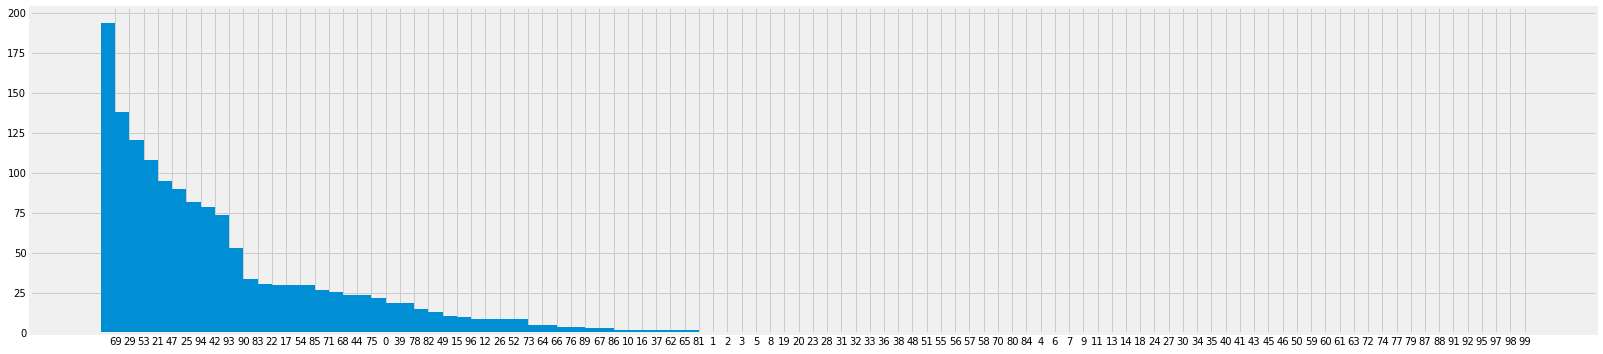

Length of query_topics: 1494
Length of query_scores: 1494
Length of corpus_df:    1494
Failed for topic 4: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 6: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 7: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 9: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 11: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 13: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 14: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 18: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 24: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 27: empty vocabulary; perhaps the documents only contain stop words
Failed for topic 30: empty vocabulary; perhaps the documents only c

In [70]:
corpus_suffix = "vsphere-6.5-last-month"
corpus = corpora.load("../corpora/"+corpus_suffix)

# convert the list of Search objects into a dataframe
corpus_df = pd.DataFrame([vars(c) for c in corpus])
print("Total number of queries: {}".format(len(corpus_df)))

# For our current purposes, the timestamp isn't needed
corpus_df = corpus_df.drop(columns=["timestamp"])
corpus_df.head()

n_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.10, min_df=1,
                                max_features=n_features,
                                stop_words='english'
                               )
# create a list of just the bodies
bodies = [c.body for c in corpus]
tf = tf_vectorizer.fit_transform(bodies)

num_topics_list = [10, 25, 50, 75, 100]

for num_topics in num_topics_list:
    print("-----------------------------------------------------")
    print("Running analysis on {} for {} topics".format(corpus_suffix, num_topics))
    print("-----------------------------------------------------")
    lda = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0,
                                    n_jobs=-1,
                                   )
    lda.fit(tf)
    model = lda
    print("Number of features: {}".format(len(model.components_[0])))

    n_top_words = 5

    tf_feature_names = tf_vectorizer.get_feature_names()

    top_words = get_top_words(model, tf_feature_names, n_top_words)
    for topic_idx, words in enumerate(top_words):
        print("Topic #{}: {}".format(topic_idx, words))
    sizes = get_doc_counts_per_topic(bodies, model, tf_vectorizer, hard_clustering=True)
    plot_doc_counts(sizes)

    #create topic_df
    topic_df = pd.DataFrame({"Key terms": top_words,
                            "Size": [val for _, val in sorted(sizes.items())]})

    # create corpus_df
    from collections import defaultdict
    query_topics = []
    query_scores = []
    topic_bodies = {}
    for idx in range(num_topics):
        topic_bodies[idx] = []
    for body in bodies:
        topic, scores = get_top_topics(body, model, tf_vectorizer, hard_clustering=True)
        query_topics.append(topic[0])
        query_scores.append(scores[0])
        topic_bodies[topic[0]].append(body)

    print("Length of query_topics: {}".format(len(query_topics)))
    print("Length of query_scores: {}".format(len(query_scores)))
    print("Length of corpus_df:    {}".format(len(corpus_df)))
    corpus_df["Topic ID"] = query_topics
    corpus_df["Score"] = query_scores

    pd.set_option('display.height', 75)
    pd.set_option('display.max_rows', 75)
    pd.set_option('display.max_colwidth', -1)
    corpus_df = corpus_df.sort_values(['Topic ID', 'Score'], ascending=[True, False])
    corpus_df

    # get top n grams
    top_1_grams = []
    top_2_grams = []
    top_3_grams = []
    for topic, topic_body in topic_bodies.items():
        top_1_grams.append(get_top_n_grams(topic_body, 1, 5))
        top_2_grams.append(get_top_n_grams(topic_body, 2, 5))
        top_3_grams.append(get_top_n_grams(topic_body, 3, 5))
    
    topic_df["Top 1-grams"] = top_1_grams
    topic_df["Top 2-grams"] = top_2_grams
    topic_df["Top 3-grams"] = top_3_grams
    topic_df

    #get best sentence
    topic_scores = defaultdict(lambda: [])

    best_sentences = {}
    for idx in range(num_topics):
        best_sentences[idx] = ""
    for topic_idx in range(num_topics):
        try: 
            best_sentences[topic_idx] = find_best_sentence(corpus_df[corpus_df["Topic ID"] == topic_idx]["body"].tolist(),
                                                           topic_df.iloc[topic_idx]["Key terms"])
        except Exception as err:
            print("Failed for topic {}: {}".format(topic_idx, err))

    topic_df["Best sentence"] = best_sentences.values()

    #save
    corpus_df = corpus_df[["Topic ID", "Score", "session_id", "body"]]
    corpus_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/documents-LDA.csv", index=False)
    topic_df.index.name = 'Topic ID'
    topic_df.to_csv("../results/"+corpus_suffix+"-"+str(num_topics)+"-topics/topics-LDA.csv")